In [0]:
#importing the standard Python modules
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline  

In [0]:
#download a test image
!wget https://users.itk.ppke.hu/~horan/cnn/hfimgs/HOLLOW.bmp
!wget https://users.itk.ppke.hu/~horan/cnn/hfimgs/madonna.bmp
!wget http://users.itk.ppke.hu/~horan/cnn/hfimgs/CONC2.bmp

--2020-03-27 09:45:52--  https://users.itk.ppke.hu/~horan/cnn/hfimgs/HOLLOW.bmp
Resolving users.itk.ppke.hu (users.itk.ppke.hu)... 193.225.109.33
Connecting to users.itk.ppke.hu (users.itk.ppke.hu)|193.225.109.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29878 (29K) [image/x-ms-bmp]
Saving to: ‘HOLLOW.bmp.1’

HOLLOW.bmp.1        100%[===================>]  29.18K  --.-KB/s    in 0.1s    

2020-03-27 09:45:53 (259 KB/s) - ‘HOLLOW.bmp.1’ saved [29878/29878]

--2020-03-27 09:45:54--  https://users.itk.ppke.hu/~horan/cnn/hfimgs/madonna.bmp
Resolving users.itk.ppke.hu (users.itk.ppke.hu)... 193.225.109.33
Connecting to users.itk.ppke.hu (users.itk.ppke.hu)|193.225.109.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4622 (4.5K) [image/x-ms-bmp]
Saving to: ‘madonna.bmp.1’

madonna.bmp.1       100%[===================>]   4.51K  --.-KB/s    in 0s      

2020-03-27 09:45:54 (115 MB/s) - ‘madonna.bmp.1’ saved [4622/4622]

--2020-03-27 

In [0]:
def Uint8ToCell(arr):
  #this function converts an array from unit8, 0-255, oBlack, 255White to -1White, 1Black
  arr = (-1.0)*(arr.astype(float)/128.0-1.0)
  return arr

In [0]:
def CellToUint8(arr):
  #this function converts an array to unit8, 0-255, oBlack, 255White to -1White, 1Black
  arr = ((-1.0)*(arr.astype(float))+1.0)*128.0
  arr = arr.astype(np.unit8)
  return arr

In [0]:
def StandardCNNNonliearity(x):
  #this function implements the standard CNN nonlinearity, all values are saturated below -1 and above 1
  back = x
  back[x<-1]=-1
  back[x>0]=1
  return back

In [0]:
class CellSim():
  def __init__(self):
      self.Input = []
      self.State = []
      self.Output = []
      self.A = np.zeros((3,3))
      self.B = np.zeros((3,3))
      self.Z = 0
      self.SimTime = 1
      self.TimeStep = 0.1
      self.OutputNonlin = StandardCNNNonliearity
      self.Boundary = 'Constant'
      self.BoundValue = 0

  def GetOutput(self):
      return self.Output

  def SetTimeStep(self,Ts):
      #this function sets the A template of the simulator    
      #check if it is an N times N matrix - later on these could be functions
      self.TimeStep = Ts

  def SetSimTime(self,T):
      #this function sets the A template of the simulator    
      #check if it is an N times N matrix - later on these could be functions
      self.SimTime = T

  def SetInput(self,In):
      #this function sets the A template of the simulator    
      #check if it is an N times N matrix - later on these could be functions
      #and convert image to CellNN domain       
      img=Uint8ToCell(cv2.cvtColor(cv2.imread(In), cv2.COLOR_BGR2GRAY) )
      self.Input = img

  def SetState(self,St):
      #this function sets the A template of the simulator    
      #check if it is an N times N matrix - later on these could be functions
      img=Uint8ToCell(cv2.cvtColor(cv2.imread(St), cv2.COLOR_BGR2GRAY) )
      self.State = img

  def SetZ(self,z):
      self.SetBias(z)

  def SetBias(self,z):
      self.Z=z

  def SetA(self,a):
      self.SetATemplate(a)

  def SetATemplate(self,a):
      #this function sets the A template of the simulator    
      #check if it is an N times N matrix - later on these could be functions
      self.A = a

  def SetB(self,b):
      self.SetBTemplate(b)

  def SetBTemplate(self,b):
      #this function sets the A template of the simulator    
      #check if it is an N times N matrix - later on these could be functions
      self.B = b
  
  def Euler(self,f,y0,StartTime,EndTime,h):
    t,y = StartTime,y0
    while t <= EndTime:
        t += h
        y += h * f(t,y)
    return y
  
  def Simulate(self):
    Ret=self.Euler(self.cell_equation,self.State.flatten(),0, self.SimTime,0.1)
    SizeX=self.State.shape[0]
    SizeY=self.State.shape[1]
    OutImg=self.OutputNonlin(np.reshape(Ret,[SizeX,SizeY]))
    return OutImg

  def cell_equation(self,t,X):
    #This function impelment the differential equation determining the standard cnn cell:
    #xdot = -x + Ay + Bu + z
    #the parameters of the CNN array (templates) are stored in P
    #reshape the 1xN input for the size of the image -ode solvers can only deal with vectors but code is more understandable if    we use arrays
    SizeX=self.State.shape[0]
    SizeY=self.State.shape[1]
    x=np.reshape(X,[SizeX,SizeY])
    #we will return the derivative in this array
    dx=np.zeros( (SizeX,SizeY))

    #go through all elements of the array
    for a in range(1,SizeX-1):
       for b in range(1,SizeY-1):
          inputregion = np.zeros((3,3))
          stateregion = np.zeros((3,3))
          
          #at the edge (boundary)
          if(a==0) or (b==0) or (a==(SizeX-1)) or (b==(SizeY-1)):
            
            for c in range(-1,2):
              for d in range(-1,2):
                if (self.Boundary == 'Constant'):
                  #virtual cells have fix value
                  if a+c<0 | b+d<0 | a+c>(SizeX-1) | b+d>(SizeY-1):
                    inputregion[c+1,d+1] = self.BoundValue
                    stateregion[c+1,d+1] = self.BoundValue
                  else:
                    inputregion[c+1,d+1] = self.Input[a+c,b+d]
                    stateregion[c+1,d+1] = x[a+c,b+d]
                elif (Self.Boundary == 'ZeroFlux'):
                  #virtual cells have the value of the closest real cell
                  inda = a+c
                  if inda<0:
                    inda=0
                  elif inda>(SizeX-1):
                    inda = SizeX-1    
                  indb = b+d
                  if indb<0:
                    indb=0
                  elif indb>(SizeY-1):
                    indb = SizeY-1
                  inputregion[c+1,d+1] = self.Input[inda,indb]
                  stateregion[c+1,d+1] = x[inda,indb]
                elif (Self.Boundary == 'Periodic'):
                  #virtual cells have the value of the next real cell on the other edge
                  inda = a+c
                  if inda<0:
                    inda=SizeX-1
                  elif inda>(SizeX-1):
                    inda = 0    
                  indb = b+d
                  if indb<0:
                    indb=SizeY-1
                  elif indb>(SizeY-1):
                    indb = 0
                  inputregion[c+1,d+1] = self.Input[inda,indb]
                  stateregion[c+1,d+1] = x[inda,indb]
          else:
            inputregion = self.Input[a-1:a+2,b-1:b+2] #U
            stateregion = x[a-1:a+2,b-1:b+2]          #X

          y = self.OutputNonlin(stateregion)        #Y
          
          #calculate the derivative according to the equation
          dx[a,b] = -x[a,b] + np.sum(np.multiply(self.A,y)) + np.sum(np.multiply(self.B,inputregion)) + self.Z
          
          
    #reshape back to Nx1
    dx=np.reshape(dx,[SizeX*SizeY])
      
    return dx

# Threshold with -0.4 intensity

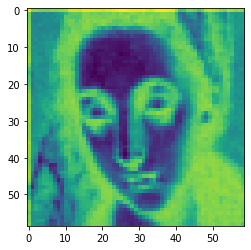

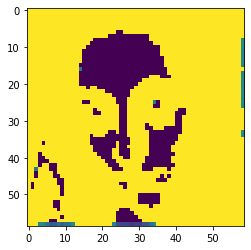

In [0]:
CNN=CellSim() #intialization of the simulator

CNN.SetTimeStep(0.1) #lépés méret
CNN.SetSimTime(5.0) #szimulációs idő
CNN.SetA([[0, 0, 0],[0, 2.0, 0],[0, 0, 0]])  #defining the values of the A template
CNN.SetB([[0, 0, 0],[0, 0, 0],[0, 0, 0]]) #defining the values of the B template
CNN.Z = 0.4 #Bias
CNN.SetInput('madonna.bmp')  #loading the input image
CNN.SetState('madonna.bmp') #loading the initial state
CNN.Boundary='Constant'  #setting the  Boundary condition

OutImg=CNN.Simulate() #executing the simulation, the function returns the output image of the CeNN array
plt.imshow(CNN.Input) #displaying the input image
plt.figure()
plt.imshow(OutImg) #displaying the output image

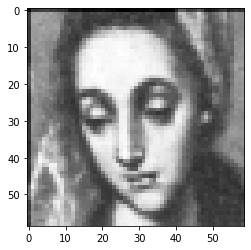

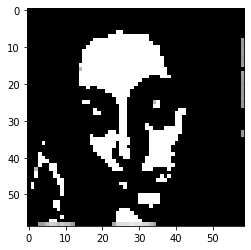

In [0]:
plt.imshow(CNN.Input,cmap='Greys') #displaying the input image
plt.figure()
plt.imshow(OutImg,cmap='Greys')
plt.savefig('out_image1.png') 

# HOLE-FILLING

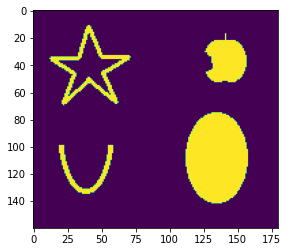

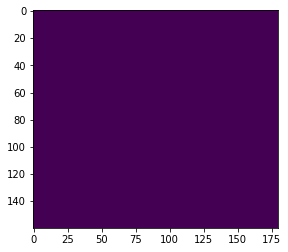

In [0]:
CNN=CellSim() #intialization of the simulator

CNN.SetTimeStep(0.1) #setting the timestep of the numerical solution
CNN.SetSimTime(90.0) #setting the running time of the simulation
CNN.SetA([[0, 1.0, 0],[1.0, 3.0, 1.0],[0, 1.0, 0]])  #defining the values of the A template
CNN.SetB([[0, 0, 0],[0, 4.0, 0],[0, 0, 0]]) #defining the values of the B template
CNN.Z = -1 #Bias72
CNN.SetInput('HOLLOW.bmp')  #loading the input image
CNN.State = np.ones(CNN.Input.shape) #loading the initial state
CNN.Boundary='Constant'  #setting the  Boundary condition

OutImg,Traj=CNN.Simulate() #executing the simulation, the function returns the output image of the CeNN array
print(OutImg.shape)
plt.imshow(CNN.Input) #displaying the input image
plt.figure()
plt.imshow(OutImg) #displaying the output image

In [0]:
plt.imshow(CNN.Input,cmap='Greys') #displaying the input image
plt.figure()
plt.imshow(OutImg,cmap='Greys')
plt.savefig('out_image3.png') 

# Shadow Up

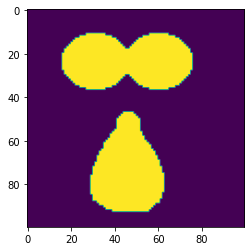

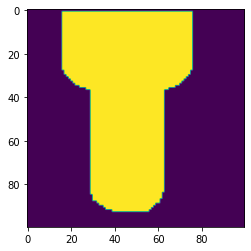

In [0]:
CNN=CellSim() #intialization of the simulator

CNN.SetTimeStep(0.1) #setting the timestep of the numerical solution
CNN.SetSimTime(40.0) #setting the running time of the simulation
CNN.SetA([[0, 0.0, 0],[0.0, 2.0, 0.0],[0, 2.0, 0]])  #defining the values of the A template
CNN.SetB([[0.0, 0.0, 0.0],[0.0, 2.0, 0.0],[0.0, 0.0, 0.0]]) #defining the values of the B template
CNN.Z = 0 #Bias
CNN.SetState('CONC2.bmp')  #loading the input image
CNN.Input = np.ones(CNN.State.shape) #loading the initial state
CNN.Boundary='ZeroFlux'  #setting the  Boundary condition

OutImg=CNN.Simulate() #executing the simulation, the function returns the output image of the CeNN array
plt.imshow(CNN.State) #displaying the input image
plt.figure()
plt.imshow(OutImg) #displaying the output image

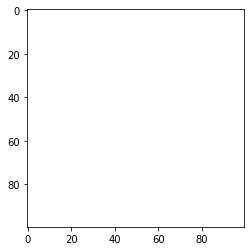

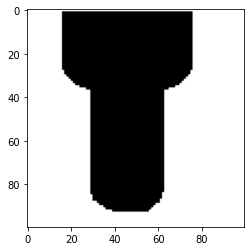

In [0]:
plt.imshow(CNN.Input,cmap='Greys') #displaying the input image
plt.figure()
plt.imshow(OutImg,cmap='Greys')
plt.savefig('out_image3.png') 